# Model visualization

In [1]:
from python.model import Model
from python.earnings import earnings_constants
from python.parameters import JOBS, CRITERION, MAXITERATIONS , \
                       AUGMA, NBA, AMIN, AMAX, AUGMH, NBH, HMIN, HMAX
from python.constants import BETA, R, IOTA, TAU, pp_range
from python.distributions import PPDDISTRIBUTION
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

Parameters of simulation:

In [2]:
PERIODS = 4                          # Number of periods for simulation
AGENTS = 1000                         # Number of agents

Moments of model (All):

In [3]:
PSI = [0.36, 0.36, 0.36] #[0.41, 0.39, 0.27]              # Labor supply elasticity
CHI = [0.05, 480, 490] #[0.36, 0.37, 0.44]              # Disutility of labor supply

Parameters of model (uncomment if you want recalculate model directly in the notebook with those parameters):

In [4]:
JOBS = 1                                  # Numbers of jobs
# CRITERION = 1e-3                          # Convergence criterion
# MAXITERATIONS = 100                       # Maximal number of iterations

# pp_range = [0, 1]                         # List of possible PP states
o_range = [False]                   # List of possible o states

ZSHOCKS = 1                           # Number of discrete earnings shocks
z_shock_range = np.array([0])  # Discrete earnings shocks range
            
# Transition matrix
PIMATRIX = np.array([1])
PIMATRIX = PIMATRIX.reshape(ZSHOCKS, ZSHOCKS)
ZDISTRIBUTION = [1]

Extended model class:

In [5]:
class NewModel(Model):
    def __init__(self, group):
        (self.PSI, self.CHI) = (PSI[group-1], CHI[group-1])
        self.bond = [0.2, 0.1, 0]
        
        (self.AMIN, self.AMAX, self.NBA) = (AMIN, AMAX, NBA)
        (self.HMIN, self.HMAX, self.NBH) = (HMIN, HMAX, NBH)
        self.AUGMA = AUGMA
        self.AUGMH = AUGMH
                
        self.JOBS = JOBS
        self.CRITERION = CRITERION
        self.MAXITERATIONS = MAXITERATIONS
        self.BETA = BETA
        self.R =  R
        self.IOTA = IOTA
        self.TAU = TAU
        self.ZSHOCKS = ZSHOCKS
        self.z_shock_range = z_shock_range
        self.pp_range = pp_range
        self.o_range = o_range
        self.PIMATRIX = PIMATRIX
        
        self.WAGECONSTANT = 3.3576
        self.ALPHA = 0.0041
        self.ZETA= [0, -0.31, -0.57, -0.28, -0.41, -0.55, -0.35, -0.63, -0.80]
        self.GAMMA = [0.7353, 0.13995, 0.017]
        self.XI = 0 #-0.09
        self.updade_parameters()
           
    def updade_parameters(self):
        if self.NBA > 1:
            self.DELTAA = (self.AMAX - self.AMIN) / (self.NBA - 1)     
        else:
            self.DELTAA = 1
        if self.NBH > 1:
            self.DELTAH = (self.HMAX - self.HMIN) / (self.NBH - 1)     
        else:
            self.DELTAH = 1

        self.a_grid = np.linspace(self.AMIN, self.AMAX, self.NBA)
        self.h_grid = np.linspace(self.HMIN, self.HMAX, self.NBH)
        
        self._size = len(self.pp_range)*len(self.o_range)*self.JOBS
        self._full_size = self.NBA*self.NBH

        dr = np.ones( (self._full_size, self.ZSHOCKS), dtype=int )
        v = np.zeros( (self._full_size, self.ZSHOCKS), dtype=float )
        self.v = [v] * ( self._size )
        self.dr = [dr] * ( self._size ) 


    def show_assets(self, i, j, k):
        plt.figure()
        plt.plot( self.a_grid, self.a_grid )
        for idx in i:
            plt.plot( self.a_grid,
                  self.a_grid[self.dr[idx].
                  reshape(self.NBH, self.NBA, self.ZSHOCKS)[j, :, k] % self.NBA] )
        plt.ylabel("next period asset")
        plt.xlabel("asset")

        plt.figure()
        for idx in i:
            plt.plot(self.a_grid, self.v[idx].
                reshape(self.NBH, self.NBA, self.ZSHOCKS)[j, :, k] )
        plt.ylabel("value function")
        plt.xlabel("asset")

        plt.show()

    def show_hours(self, i, j, k):
        plt.figure()
        plt.plot( self.h_grid, self.h_grid )
        for idx in i:
            plt.plot( self.h_grid,
                     self.h_grid[self.dr[idx].
                     reshape(self.NBH, self.NBA, self.ZSHOCKS)[:, j, k] // self.NBA] )
        plt.ylabel("next period cumulative hours worked")
        plt.xlabel("cumulative hours worked")

        plt.figure()
        for idx in i:
            plt.plot(self.h_grid, self.v[idx].
                    reshape(self.NBH, self.NBA, self.ZSHOCKS)[:, j, k] )
        plt.ylabel("value function")
        plt.xlabel("cumulative hours worked")

        plt.show()
        
    def grid_wage(self, j, pp, h_prime, h, o, z_shock):
        '''
        Earnings function on grid
        
        :param int j: current job type
        :param int pp: 1 = receiving PP, 0 = not receiving PP
        :param int h_prime: next period cumulative hours worked
        :param int h: current peruod cumulative hours worked
        :param bool o: True = changed job, False = kept job
        :param int z_shock: z-shock index
        '''
        if h > self.HMAX - self.bond[0]*self.AUGMH:
            _h = (self.bond[1] + self.bond[2]*pp)*self.AUGMH
        else:
            _h = h_prime - h
        return self.wage(j, pp, _h, h, o, self.z_shock_range[z_shock])
    
    def consumption(self, a_prime, a, w):
        '''
        Consumption
        
        :param float a_prime: next period assets
        :param float a: current peruod assets
        :param float w: wage
        '''
        return (1 + self.R)*a - a_prime + (1 - self.TAU)*w
    
    def utility_matrix(self, index):
        (pp, j, o) = self.map_from_index(index)
        _temp_um = np.zeros((self._full_size, self._full_size, 
                                         self.ZSHOCKS), dtype=float)
        _temp_um.fill(np.nan) 
        for z_shock in range(self.ZSHOCKS): 
            for h_start in self.h_grid:
                for a_start in self.a_grid:
                    for h_end in self.h_grid:
                        if h_end < h_start or h_end - h_start > self.AUGMH:
                            continue
                        for a_end in self.a_grid:
                            if abs(a_end - a_start) > self.AUGMA:
                                continue
                            _c = self.grid_consumption(j, pp, h_end, h_start, 
                                                 a_end, a_start, o, z_shock);
                            if _c <= 0:
                                continue
                            if h_start > self.HMAX - self.bond[0]*self.AUGMH:
                                _l = self.bond[1] + self.bond[2]*pp
                            else:
                                _l = self.grid_labor(h_end, h_start)
                            _idx_1 = self.map_from_grid(a_start, h_start)
                            _idx_2 = self.map_from_grid(a_end, h_end)
                            _temp_um[_idx_1, _idx_2, z_shock] = \
                                     self.utility(_c, _l)
        print("Matrix: {0:2d}; Utility matrix calculated".format(index))
        return _temp_um
    

    
    def utility(self, c, l):
        '''
        Utility function on grid

        :param float c: consumption on grid
        :param float l: labor supply on grid
        '''
#         if c > 1:
#             _c = np.log(c)
#         else:
        _c = c
        return (_c**(1-self.IOTA))/(1-self.IOTA) - \
               self.CHI*(l**(1+self.PSI))/(1+self.PSI) + np.euler_gamma

In [6]:
def simulate_agent(m, st_idx, log=True):
    _dr_idx = st_idx #rnd.randint(0, 5)*m.NBA + rnd.randint(m.NBA // 4, m.NBA // 2)
    _maxpp = len(PPDDISTRIBUTION[0])
    _h = m.HMIN + (_dr_idx // m.NBA)*m.DELTAH
    _a = m.AMIN + (_dr_idx % m.NBA)*m.DELTAA
    res = np.array( [(0, 0, 0, 0.0, 0.0, 0.0, 0.0)]*PERIODS )
    if log:
        print(" Period| Job| PP| Shock|     h|      a|    l|     c|     w ")
        print(" {0:6d}|   -|  -|     -|{1:6.0f}|{2: 6.0f}|    -|     -|     -".
                format(0, np.log(_h), _a) )
    for period in range(PERIODS):    
        if period >= _maxpp:
            _per = _maxpp - 1
        else:
            _per = period
        _pp_prob = rnd.random()
        if (_pp_prob < PPDDISTRIBUTION[0][_per]):
            pp = 1
        else:
            pp = 0
        _temp_idx = m.dr[m.map_to_index(pp, 0, False)].reshape(m.NBA*m.NBH, m.ZSHOCKS)[_dr_idx, 0]
        _l = m.labor(m.h_grid[_temp_idx // m.NBA], 
                    m.h_grid[_dr_idx // m.NBA]) / m.AUGMH

        _w = m.wage(0, pp, _l*m.AUGMH, 
                    m.h_grid[_dr_idx // m.NBA], 
                    False, 0)
        
        _c = m.consumption(m.a_grid[_temp_idx % m.NBA], m.a_grid[_dr_idx % m.NBA], _w)
        _dr_idx = _temp_idx
        _h = m.h_grid[_dr_idx // m.NBA]
        _a = m.a_grid[_dr_idx % m.NBA]
        
        res[period] = (period + 1, 0, 
                    pp, 
                    _h, _l*m.AUGMH, _c, _w)
        if log:
            print(" {0:6d}|{1: 4d}|{2: 3d}|{3: 6.2f}|".
                    format(period + 1, 0, pp, 0) +
                    "{0:6.2f}|{1: 6.0f}|{2: 5.4f}|{3: 6.0f}|{4: 6.3f}".
                        format(np.log(_h), _a, _l, _c, np.log(_w)) )
    return res
        
def integrate(m):
    average_pp_0 = np.array( [(0, 0, 0, 0.0, 0.0, 0.0, 0.0)]*(PERIODS) )
    average_pp_1 = np.array( [(0, 0, 0, 0.0, 0.0, 0.0, 0.0)]*(PERIODS) )
    index_pp_0 = np.array( [0]*(PERIODS) )
    index_pp_1 = np.array( [0]*(PERIODS) )

    for agent in range(AGENTS):
        _temp_agent = simulate_agent(m, rnd.randint(0, 2), log=False)
        for period in range(PERIODS):
            if _temp_agent[period][2] == 0:
                average_pp_0[period] += _temp_agent[period]
                index_pp_0[period] += 1
            else:
                average_pp_1[period] += _temp_agent[period]
                index_pp_1[period] += 1
    for period in range(PERIODS):
        average_pp_0[period] /= index_pp_0[period]
        average_pp_1[period] /= index_pp_1[period]
    return (average_pp_0, average_pp_1)

def print_res(result):
    print("     h|       l|       c|       w ")
    for period in range(PERIODS):   
        (_p, _j, _pp, _h, _l, _c, _w) = tuple(result[period])       
        print("{0: 6.0f}|{1: 5.2f}|{2: 8.0f}|{3: 8.2f}".
                        format(_h, _l, _c, _w ) )

Model evaluation (uncomment for new model directly from the notebook):

4000 21280
Matrix:  0; Utility matrix calculated
Matrix:  1; Utility matrix calculated
Matrix:  1; Iteration: 81; Distance: 0
Matrix:  0; Iteration: 81; Distance: 0


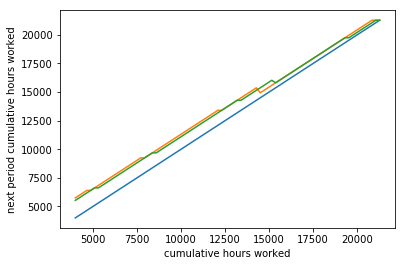

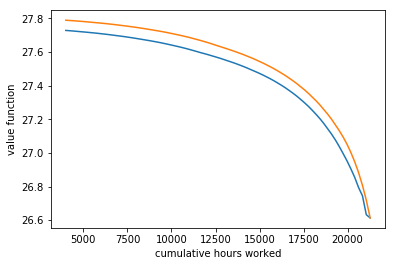

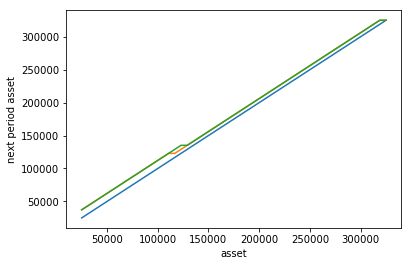

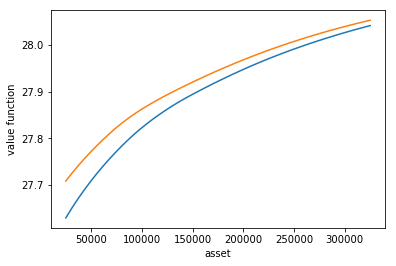

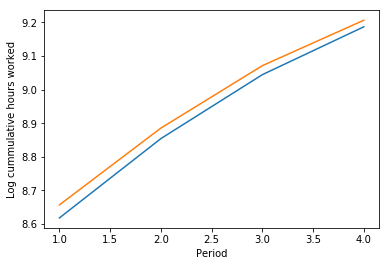

 Period| Job| PP| Shock|     h|      a|    l|     c|     w 
      0|   -|  -|     -|     8| 25000|    -|     -|     -
      1|   0|  0|  0.00|  8.66| 37245| 0.4051|  4536| 10.009
      2|   0|  0|  0.00|  8.89| 49490| 0.3544|  4295| 9.962
      3|   0|  0|  0.00|  9.08| 61735| 0.3544|  5291| 9.995
      4|   0|  0|  0.00|  9.22| 73980| 0.3038|  4490| 9.908
 Period| Job| PP| Shock|     h|      a|    l|     c|     w 
      0|   -|  -|     -|     8| 31122|    -|     -|     -
      1|   0|  1|  0.00|  8.62| 43367| 0.3544|  5539| 10.056
      2|   0|  0|  0.00|  8.86| 55612| 0.3544|  4459| 9.956
      3|   0|  0|  0.00|  9.06| 67857| 0.3544|  5469| 9.990
      4|   0|  1|  0.00|  9.18| 80102| 0.2532|  5030| 9.929
16960 34240
Matrix:  0; Utility matrix calculated
Matrix:  1; Utility matrix calculated
Matrix:  1; Iteration: 66; Distance: 0
Matrix:  0; Iteration: 81; Distance: 0


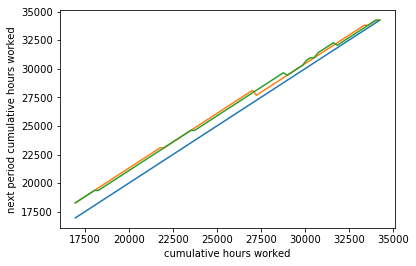

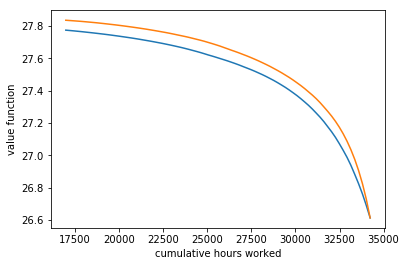

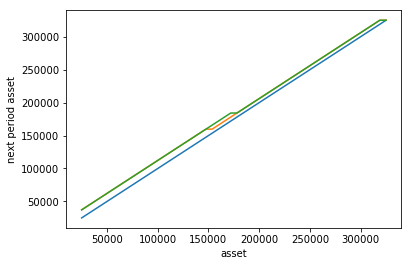

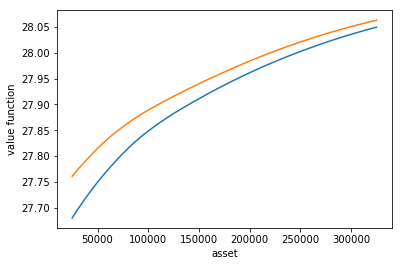

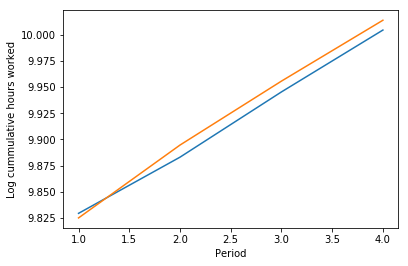

 Period| Job| PP| Shock|     h|      a|    l|     c|     w 
      0|   -|  -|     -|    10| 25000|    -|     -|     -
      1|   0|  0|  0.00|  9.83| 37245| 0.3544|  6265| 10.113
      2|   0|  1|  0.00|  9.88| 49490| 0.2532|  5667| 10.049
      3|   0|  0|  0.00|  9.95| 61735| 0.3038|  5687| 10.020
      4|   0|  1|  0.00| 10.00| 73980| 0.2532|  6965| 10.068
 Period| Job| PP| Shock|     h|      a|    l|     c|     w 
      0|   -|  -|     -|    10| 31122|    -|     -|     -
      1|   0|  0|  0.00|  9.83| 43367| 0.3544|  6510| 10.113
      2|   0|  0|  0.00|  9.89| 55612| 0.3038|  5314| 10.012
      3|   0|  0|  0.00|  9.96| 67857| 0.3038|  5956| 10.021
      4|   0|  0|  0.00| 10.02| 80102| 0.3038|  6590| 10.030
29920 47200
Matrix:  0; Utility matrix calculated
Matrix:  1; Utility matrix calculated
Matrix:  1; Iteration: 66; Distance: 0
Matrix:  0; Iteration: 81; Distance: 0


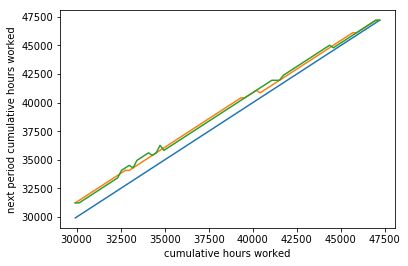

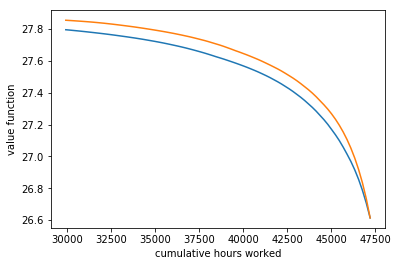

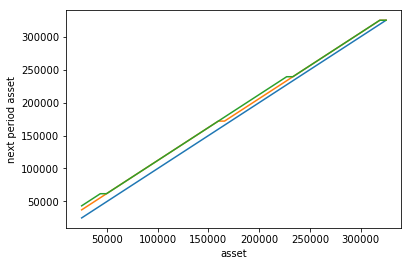

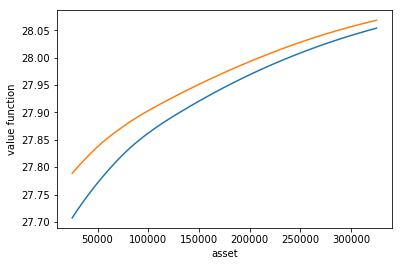

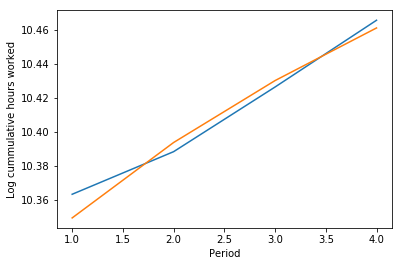

 Period| Job| PP| Shock|     h|      a|    l|     c|     w 
      0|   -|  -|     -|    10| 25000|    -|     -|     -
      1|   0|  0|  0.00| 10.35| 37245| 0.3038|  5682| 10.079
      2|   0|  1|  0.00| 10.38| 49490| 0.2532|  7075| 10.131
      3|   0|  0|  0.00| 10.42| 61735| 0.3038|  6846| 10.090
      4|   0|  1|  0.00| 10.47| 80102| 0.3544|  7204| 10.390
 Period| Job| PP| Shock|     h|      a|    l|     c|     w 
      0|   -|  -|     -|    10| 31122|    -|     -|     -
      1|   0|  0|  0.00| 10.35| 43367| 0.3038|  5927| 10.079
      2|   0|  0|  0.00| 10.39| 55612| 0.3038|  6518| 10.085
      3|   0|  1|  0.00| 10.42| 67857| 0.2532|  7925| 10.138
      4|   0|  1|  0.00| 10.46| 80102| 0.2532|  8508| 10.143


In [12]:
temp1 = [0.09, 0.15, 0.19]
temp2 = [0.3, 0.3, 0.3]
temp3 = [0.05, 0.05, 0.1]


for idx in range(3):
#     print("Group " + str(group + 1) + " CHI: " + str(CHI[group]) + " PSI: " + str(PSI[group]))
    m = NewModel(1)
    m.bond = [0, 0.3, 0]

    m.HMIN = 4000 + m.AUGMH*idx*(PERIODS - 1)
    m.HMAX = m.HMIN + m.AUGMH*PERIODS
    m.NBH = 20*PERIODS    

    m.AMIN = 25000                              # Minimal value of assets
    m.AMAX = 325000                             # Maximal value of assets
    m.NBA = 50                                  # Number of assets points in the grid
    
    print(m.HMIN, m.HMAX)
    m.updade_parameters()
    m.evaluate_model()
    m.show_hours([0,1],4,0)
#     m.show_assets([0,1],10,0)
    (res0, res1) = integrate(m)
    plt.figure()
    plt.plot(np.linspace(1,PERIODS,PERIODS), np.log(res1[:,3]))
    plt.plot(np.linspace(1,PERIODS,PERIODS), np.log(res0[:,3]))
    plt.xlabel("Period")
    plt.ylabel("Log cummulative hours worked")
    plt.show()
    res_1 = simulate_agent(m, 0)
    res_1 = simulate_agent(m, 1)

Uncomment if you want save results to file

In [ ]:
# m.save_to_csv(group)
# m.load_from_csv(1)

In [ ]:
m.show_assets([0,1],50,0)

Hours worked policy (regime index, asset index, shock index):

In [ ]:
m.show_hours([0,1],4,0)

Simulate one agent:

In [ ]:
res_1 = simulate_agent(m, 1)

Simulate all agents:

In [ ]:
(res0, res1) = integrate(m)

Average log earnings and cumulative hours worked versus period:

In [ ]:
plt.figure()
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res1[1:,6]))
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res0[1:,6]))

plt.xlabel("Period")
plt.ylabel("Log earnings")
plt.figure()
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res1[1:,3]))
plt.plot(np.linspace(1,PERIODS-1,PERIODS-1), np.log(res0[1:,3]))

plt.xlabel("Period")
plt.ylabel("Log cummulative hours worked")
plt.show()

In [ ]:
df = pd.concat([pd.DataFrame(np.log(res0[1:,6])), pd.DataFrame(np.log(res1[1:,6])), pd.DataFrame(np.log(res0[1:,3])), pd.DataFrame(np.log(res1[1:,3]))], axis=1)

In [ ]:
df.to_csv("sim_mom.csv", header = True, index=False)

Load model data for Group 2 from existing file

In [ ]:
np.log([res0[1,3],res1[1,3]])

Average log earnings and cumulative hours worked versus period:

Load model data for Group 3 from existing file